In [5]:
try:
    import captum
except:
    !pip install captum
    
try:
    import flask_compress
except:
    !pip install flask_compress
    
try:
    import fastai
except:
    !pip install fastai
    
    
try:
    import albumentations
except:
    !pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 KB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 6.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 7.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 KB 4.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 7.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 8.2 MB/s eta 0:00:0000:0100:01m


<hr style="border: solid 3px blue;">

# Introduction

![](https://3starlearningexperiences.files.wordpress.com/2018/12/giants.jpg)

Picture Credit: https://3starlearningexperiences.files.wordpress.com/

<span style="color:Blue"> **Standing on the shoulders of giants**
> The phrase Standing on the shoulders of giants is a metaphor which means "Using the understanding gained by major thinkers who have gone before in order to make intellectual progress".
> 
> It is a metaphor of dwarfs standing on the shoulders of giants (Latin: nanos gigantum umeris insidentes) and expresses the meaning of "discovering truth by building on previous discoveries". This concept has been dated to the 12th century and, according to John of Salisbury, is attributed to Bernard of Chartres. But its most familiar and popular expression occurs in a 1675 letter by Isaac Newton: "If I have seen further it is by standing on the shoulders of Giants."

Ref: https://en.wikipedia.org/wiki/Standing_on_the_shoulders_of_giants

In this notebook, we are going to solve the problem of classifying bird species using a well-made library.
In general, data collection and labeling is an expensive and difficult task. However, when learning using unstructured data such as images, a lot of data is required.
One of the ways to solve this problem is data augumentation. We have a giant in data augmentation. Almentation supports various data augumentation methods for image processing.

We want to make data preprocessing and modeling easy and effective. There is also a giant about this, fastai. Fastai provides various convenient APIs so that you can easily access the latest technologies.

Finally, we want to know if the model works well and why we make that decision. For this, we use a giant called captum.

---------------------------------------------
# Setting Up

In [6]:
from captum.attr import IntegratedGradients,NoiseTunnel,GradientShap,Occlusion
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap

from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

from fastai.vision.all import *
import albumentations
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
sns.set(style="ticks", context="talk",font_scale = 1)
plt.style.use("dark_background")

-----------------------------------------
# Data Augumentation

![](https://www.mdpi.com/sensors/sensors-21-08444/article_deploy/html/images/sensors-21-08444-g001-550.jpg)

Picture Credit: https://www.mdpi.com/sensors

> Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model. It is closely related to oversampling in data analysis.

Ref: https://en.wikipedia.org/wiki/Data_augmentation

In [8]:
def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(300,300),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

----------------------------------------------
# What is Albumtation

![](https://cf.shopee.ph/file/a258e31d4587b7674f39cfb03cacead0)

Picture Credit: https://cf.shopee.ph
> Albumentation is a fast image augmentation library and easy to use with other libraries as a wrapper. The package is written on NumPy, OpenCV, and imgaug. What makes this library different is the number of data augmentation techniques that are available. While most of the augmentation libraries include techniques like cropping, flipping, rotating and scaling, albumentation provides a range of very extensive image augmentation techniques like contrast, blur and channel shuffle.

Ref: https://analyticsindiamag.com/hands-on-guide-to-albumentation

In [9]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

-----------------------------------------
# Data Loader

![](https://d2.naver.com/content/images/2021/01/fa792900-5214-11eb-9749-1c28542daaf2.png)

Picture Credit: https://d2.naver.com/content

-------------------------------------
## Making Dataloader and Checking Batch without Data Augumentation

In [11]:
path = './bird-species-classification-220-categories/Train'
fnames = get_image_files(path)
splits = RandomSplitter(valid_pct=0.2)
dls_org = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y     = parent_label,
                splitter  = splits,
                item_tfms=Resize(600)).dataloaders(path,bs=16)

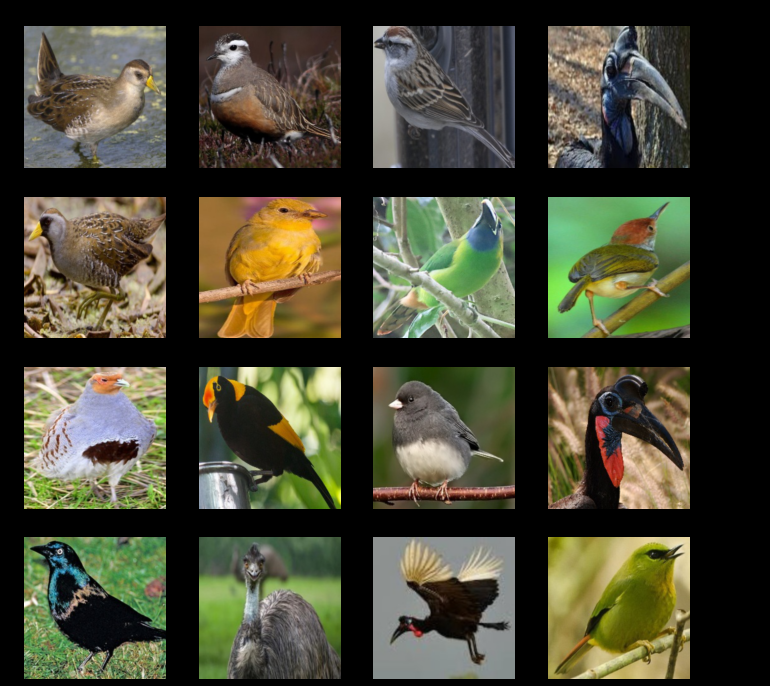

In [12]:
dls_org.show_batch(max_n=16)

The above pictures are only resized pictures.

-------------------------------------
## Making Dataloader and Checking Batch without Data Augumentation

Let's create a pipeline and a dataloader.

In [13]:
item_tfms = [Resize(600), AlbumentationsTransform(get_train_aug())]

/opt/homebrew/Caskroom/miniforge/base/envs/erdos_bootcamp_2022/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [14]:
dls = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y     = parent_label,
                splitter  = splits,
                item_tfms=item_tfms).dataloaders(path,bs=16)

Let's check the batch data after data augmentation.

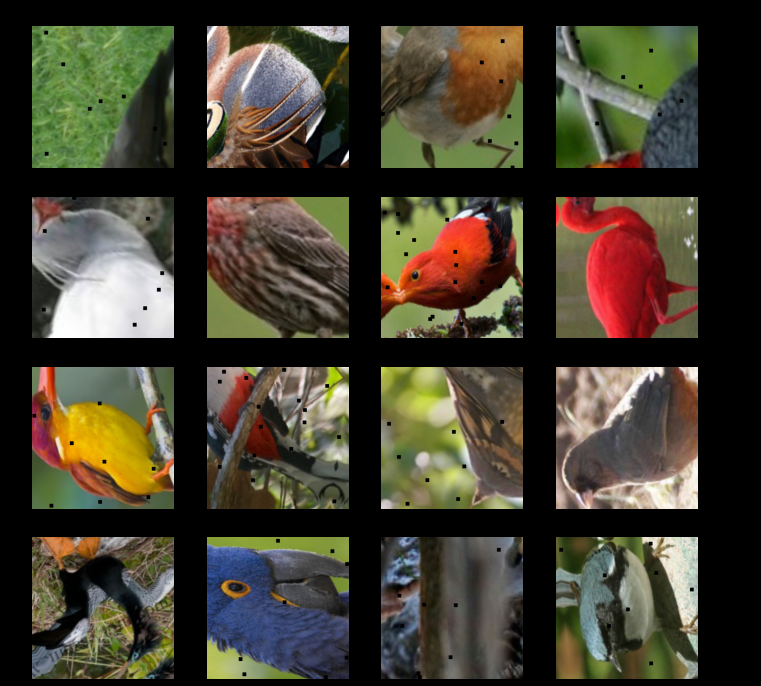

In [15]:
dls.show_batch(max_n=16)

The above pictures are pictures that have been data augumented using the albumentations libray. In the original figure, it can be seen that data has been augmented in various shapes.

-----------------------------------------
# Transfer learning

> Transfer learning is a technique where you use a model trained on a very large dataset (usually ImageNet in computer vision) and then adapt it to your own dataset. The idea is that it has learned to recognize many features on all of this data, and that you will benefit from this knowledge, especially if your dataset is small, compared to starting from a randomly initialized model. It has been proved in this article on a wide range of tasks that transfer learning nearly always give better results.
> The cnn_learner factory method helps you to automatically get a pretrained model from a given architecture with a custom head that is suitable for your data.

Ref: https://fastai1.fast.ai/

In [16]:
learn = cnn_learner(dls, 
                    resnet18, 
                    metrics=[accuracy, top_k_accuracy],
                    cbs = [EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=5),ActivationStats(with_hist=True)])

/opt/homebrew/Caskroom/miniforge/base/envs/erdos_bootcamp_2022/lib/python3.10/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/allisonlonderee/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
52.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


----------------------------------------------------------
## Resnet18

![](https://imgs.developpaper.com/imgs/188369612-fb4666aecbea518d_fix732.png)

Picture Credit: https://imgs.developpaper.com

We decided to use resnet18. Let's check this model.

In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

---------------------
# Finding the proper learning rate

![](https://miro.medium.com/max/1200/1*Q-2Wh0Xcy6fsGkbPFJvMhQ.gif)

Picture Credit: https://miro.medium.com

As shown in the figure above, if the learning rate is selected too large, divergence occurs, and if the learning rate is selected too small, convergence is delayed. Learning rate is one of the important hyperparameters used in deep learning and has a great influence on performance. In general, there is a tendency to determine the learning rate through various experiments, but fast.ai provides a method to find the learning rate.

We decided to leave the troublesome task of determining the learning rate to the machine and focus on more creative work.

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
sr = learn.lr_find()
sr.valley

/opt/homebrew/Caskroom/miniforge/base/envs/erdos_bootcamp_2022/lib/python3.10/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

---------------------------
# Training

Here, we apply top 5 accuracy as the metric.

In [ ]:
learn.fit_one_cycle(10,sr.valley)

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
learn.recorder.plot_loss()

--------------------------------------------------
# Checking Activation Statistics

In [ ]:
def plot_layer_stats(self, idx):
    plt,axs = subplots(1, 3, figsize=(15,3))
    plt.subplots_adjust(wspace=0.5)
    for o,ax,title in zip(self.layer_stats(idx),axs,('mean','std','% near zero')):
        ax.plot(o)
        ax.set_title(f"{-1*layer}th layer {title}")

Two layers with the last fully connected layers are important, so We will only draw these.

In [ ]:
for layer in range(1,3):
    plot_layer_stats(learn.activation_stats,-1*layer)

The above figures are statistics on the activation of each layer. If the activation values ​​are distributed near zero, it seems difficult to judge that the learning is done properly.

-------------------------------------------
# Activations Histogram

![](https://forums.fast.ai/uploads/default/original/3X/5/7/57a02a03d86a56561484aee9e88222ecbb7c1cf5.jpeg)


<span style="color:Blue"> **Colorful Dimension**
> The idea of the colorful dimension is to express with colors the mean and standard deviation of activations for each batch during training. Vertical axis represents a group (bin) of activation values. Each column in the horizontal axis is a batch. The colours represent how many activations for that batch have a value in that bin.

Ref: https://forums.fast.ai/

In [ ]:
def color_dim(self, idx, figsize=(15,10), ax=None):
    res = self.hist(idx)
    if ax is None: ax = subplots(figsize=figsize)[1][0]
    ax.imshow(res, origin='lower')
    ax.set_title(f"{idx}th activation histogram")
    ax.axis('off')

Two layers with the last fully connected layers are important, so We will only draw these.

In [ ]:
matplotlib.rcParams['image.cmap'] = 'rainbow_r'
for layer in range(1,3):
    color_dim(learn.activation_stats,-1*layer,figsize=(15,10))

We can check whether the learning was successful through the activation histogram of each layer. If the learning was done well, the colors would have been distributed evenly.

----------------------------------------------------------------
# Checking Result

In [ ]:
learn.show_results(figsize=(20,20))

Let's draw the data with the largest loss.

------------------------------------------------
# Interpreting

![](https://www.nature.com/news/widget_assets_polopoly/gifs/Black_box_AI_nature.gif)

Picture Credit: https://www.nature.com/news

**What is CaptumInterpretation?**
> CaptumInterpretation computes which features are important to a neural network when making a prediction on a particular data point. This helps users understand which features their network relies on. Since its introduction, integrated gradients has been used to interpret networks trained on a variety of data types, including retinal fundus images and electrocardiogram recordings.

Ref: https://distill.pub/2020/attribution-baselines/

In [ ]:
class CaptumInterpretation():
    "Captum Interpretation for Resnet"
    def __init__(self,learn,cmap_name='viridis',colors=None,N=256,methods=('original_image','heat_map'),
                 signs=("all", "positive"),outlier_perc=1):
        if colors is None: colors = [(0, '#ffffff'),(0.25, '#000000'),(1, '#000000')]
        store_attr()
        self.dls,self.model = learn.dls,self.learn.model
        self.supported_metrics=['IG','NT','Occl']

    def get_baseline_img(self, img_tensor,baseline_type):
        baseline_img=None
        if baseline_type=='zeros': baseline_img= img_tensor*0
        if baseline_type=='uniform': baseline_img= torch.rand(img_tensor.shape)
        if baseline_type=='gauss':
            baseline_img= (torch.rand(img_tensor.shape).to(self.dls.device)+img_tensor)/2
        return baseline_img.to(self.dls.device)

    def visualize(self,inp,metric='IG',n_steps=1000,baseline_type='zeros',nt_type='smoothgrad', strides=(3,4,4), sliding_window_shapes=(3,15,15)):
        if metric not in self.supported_metrics:
            raise Exception(f"Metric {metric} is not supported. Currently {self.supported_metrics} are only supported")
        tls = L([TfmdLists(inp, t) for t in L(ifnone(self.dls.tfms,[None]))])
        inp_data=list(zip(*(tls[0],tls[1])))[0]
        enc_data,dec_data=self._get_enc_dec_data(inp_data)
        attributions=self._get_attributions(enc_data,metric,n_steps,nt_type,baseline_type,strides,sliding_window_shapes)
        self._viz(attributions,dec_data,metric)

    def _viz(self,attributions,dec_data,metric):
        default_cmap = LinearSegmentedColormap.from_list(self.cmap_name,self.colors, N=self.N)
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                              np.transpose(dec_data[0].numpy(), (1,2,0)),
                                              methods=self.methods,
                                              cmap=default_cmap,
                                              show_colorbar=True,
                                              signs=self.signs,
                                              outlier_perc=self.outlier_perc, titles=[f'Original Image - ({dec_data[1]})', metric])



    def _get_enc_dec_data(self,inp_data):
        dec_data=self.dls.after_item(inp_data)
        enc_data=self.dls.after_batch(to_device(self.dls.before_batch(dec_data),self.dls.device))
        return(enc_data,dec_data)

    def _get_attributions(self,enc_data,metric,n_steps,nt_type,baseline_type,strides,sliding_window_shapes):
        # Get Baseline
        baseline=self.get_baseline_img(enc_data[0],baseline_type)
        supported_metrics ={}
        if metric == 'IG':
            self._int_grads = self._int_grads if hasattr(self,'_int_grads') else IntegratedGradients(self.model)
            return self._int_grads.attribute(enc_data[0],baseline, target=enc_data[1], n_steps=200)
        elif metric == 'NT':
            self._int_grads = self._int_grads if hasattr(self,'_int_grads') else IntegratedGradients(self.model)
            self._noise_tunnel= self._noise_tunnel if hasattr(self,'_noise_tunnel') else NoiseTunnel(self._int_grads)
            return self._noise_tunnel.attribute(enc_data[0].to(self.dls.device), n_samples=1, nt_type=nt_type, target=enc_data[1])
        elif metric == 'Occl':
            self._occlusion = self._occlusion if hasattr(self,'_occlusion') else Occlusion(self.model)
            return self._occlusion.attribute(enc_data[0].to(self.dls.device),
                                       strides = strides,
                                       target=enc_data[1],
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baseline)

In [ ]:
captum=CaptumInterpretation(learn,colors=['green','red','yellow'])
idx=randint(0,len(fnames))
captum.visualize(fnames[idx])

In [ ]:
captum.visualize(fnames[idx],metric='Occl',baseline_type='gauss')

In [ ]:
captum.visualize(fnames[idx],metric='IG',baseline_type='uniform')

If you look at the pictures above, you can see how our model makes decisions. It seems to capture the characteristics of each bird well.

<hr style="border: solid 3px blue;">
